# Examples of time-series forecasting with Python

- Building on the excellent (and freely available!) [Forecasting: Principles and Practice (3rd edition)](https://otexts.com/fpp3/) by Hyndman and Athanasopoulos, this notebooks presents a number of examples using the following Python libraries:
  - [`statsmodels.tsa`](https://www.statsmodels.org/stable/tsa.html) as the basis for time-series analysis
  - [`pmdarima`](http://alkaline-ml.com/pmdarima/index.html) which wraps `statsmodels` into a convenient `auto.arima` function like in R
  - TO DO: [`sktime`](https://sktime.org) as the new, unified framework for machine learning in Python
- Use [Altair](https://altair-viz.github.io/index.html) for plotting, as an example how to use this library throughout your workflow

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import rdata
import requests


# https://altair-viz.github.io/user_guide/faq.html#local-filesystem
# alt.data_transformers.enable("json")


def read_rda(url):
    """Reads .rda file from URL and returns dict with values.
    
    """
    r = requests.get(url)
    parsed = rdata.parser.parse_data(r.content)
    return rdata.conversion.convert(parsed)

## EDA with an interactive dashboard


### Bike sharing dataset

As an example, we will explore the bike sharing dataset, taken from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

#### Data Set Information

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

#### Attribute Information

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [2]:
def parse_date_hour(date, hour):
    """Construct datetime for index of hourly data."""
    return pd.to_datetime(" ".join([date, str(hour).zfill(2)]), format="%Y-%m-%d %H")


daily = pd.read_csv("./bike-sharing/bike-sharing-daily-processed.csv", parse_dates=["dteday"]).drop(
    columns=["instant", "Unnamed: 0"]
)
hourly = pd.read_csv("./bike-sharing/hour.csv").drop(columns=["instant"])
hourly.index = pd.DatetimeIndex(
    hourly.apply(lambda row: parse_date_hour(row.dteday, row.hr), axis=1),
    name="timestamp",
)
daily.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,days_since_2011
0,2011-01-01,SPRING,2011,1,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,28.363250,80.5833,10.749882,331,654,985,0
1,2011-01-02,SPRING,2011,1,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,28.027126,69.6087,16.652113,131,670,801,1
2,2011-01-03,SPRING,2011,1,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,22.439770,43.7273,16.636703,120,1229,1349,2
3,2011-01-04,SPRING,2011,1,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,23.212148,59.0435,10.739832,108,1454,1562,3
4,2011-01-05,SPRING,2011,1,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,23.795180,43.6957,12.522300,82,1518,1600,4


In [3]:
brush = alt.selection(type='interval', encodings=['x'])

base = (alt
 .Chart(daily)
 .mark_line()
 .encode(x='dteday', y='cnt')
 .properties(width=700, height=200)
 )

overview = base.properties(height=50).add_selection(brush)
detail = base.encode(alt.X('dteday:T', scale=alt.Scale(domain=brush)))

In [4]:
detail & overview

alt.VConcatChart(...)

In [5]:
monthly = daily.groupby(['yr', 'mnth'], as_index=False)['cnt'].sum('cnt')
monthly['yr_mnth'] = monthly.apply(lambda df: '-'.join([str(df.yr), str(df.mnth).zfill(2)]), axis=1)

def simple_ts_plot(df, x='yr_mnth', y='cnt', width=700, height=200):
    return alt.Chart(df).mark_line().encode(x=x, y=y).properties(width=width)

In [6]:
simple_ts_plot(monthly)

alt.Chart(...)

### Decomposition

#### Simple decomposition (`statsmodels`)

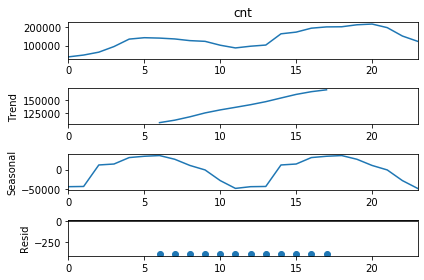

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

simple_decomposition = seasonal_decompose(monthly.cnt, period=12)
simple_decomposition.plot();

#### STL decomposition (`statsmodels`)

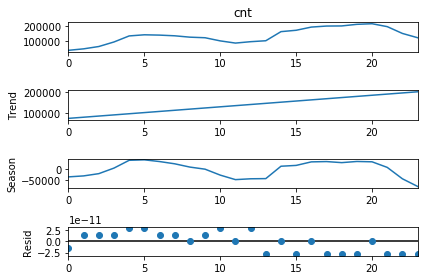

In [8]:
stl = STL(monthly.cnt, period=12).fit()
stl.plot();

Let's make those plots better looking with Altair.

In [9]:
_ts = {}
for result in ['observed', 'trend', 'seasonal', 'resid']:
    df = pd.DataFrame({'yr_mnth': monthly.yr_mnth, result: getattr(stl, result)})
    _ts[result] = simple_ts_plot(df, x='yr_mnth', y=result, height=50)


alt.vconcat(*_ts.values()).resolve_scale(x='shared')

alt.VConcatChart(...)

#### Seasonal decomposition (`pmdarima`)

Same result as `statsmodels` `seasonal_decompose`.

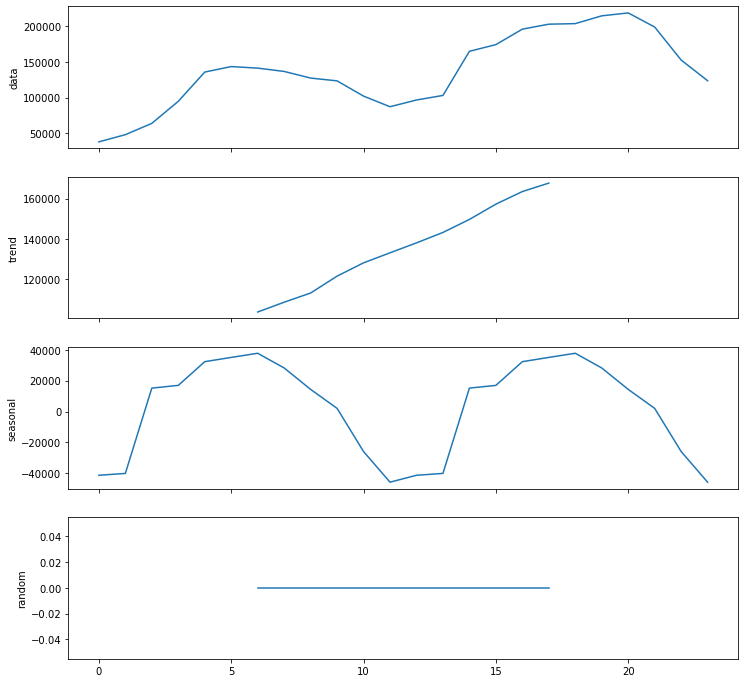

In [10]:
from pmdarima import arima, utils

# note pmdarima expects nd.array as input
arima_decomp = arima.decompose(monthly.cnt.values, type_='additive', m=12)
utils.decomposed_plot(arima_decomp, figure_kwargs={'figsize': (12,12)})

## Forecasting with ETS

We will reproduce the analysis from [FPP2 section 7.7](https://otexts.com/fpp2/ets-forecasting.html) in Python. following the [example from the statsmodels documentation](https://www.statsmodels.org/stable/examples/notebooks/generated/ets.html).

### Get data: international visitor nights in Australia

In [11]:
# read data and set proper DateRangeIndex in pandas
austourists_url = "https://github.com/robjhyndman/fpp2-package/blob/master/data/austourists.rda?raw=true" 
austourists_data = read_rda(austourists_url)
austourists = pd.DataFrame(austourists_data).set_index(
    pd.period_range(start="1999Q1", end="2015Q4", freq="Q")
)
austourists.head()

,austourists
1999Q1,30.052513
1999Q2,19.148496
1999Q3,25.317692
1999Q4,27.591437
2000Q1,32.076456


### Forecast ETS(M, A, M) model

Note: use `exponential_smoothing.ETSModel` and not`holtwinters.ExponentialSmoothing`

In [12]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel


aust_ets = ETSModel(
    austourists.austourists.rename('observed'), # NB: only take 1D array or pd.Series
    error="mul",
    trend="add",
    seasonal="mul",
    damped_trend=True,
    seasonal_periods=4
).fit(maxiter=10000)

print(aust_ets.summary())

                                 ETS Results                                  
Dep. Variable:               observed   No. Observations:                   68
Model:                      ETS(MAdM)   Log Likelihood                -149.353
Date:                Sun, 31 Oct 2021   AIC                            320.706
Time:                        16:35:53   BIC                            345.120
Sample:                    03-31-1999   HQIC                           330.379
                         - 12-31-2015   Scale                            0.003
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4969      0.112      4.452      0.000       0.278       0.716
smoothing_trend     4.969e-05      0.009      0.005      0.996      -0.018       0.018
smoothing_seasonal  

In [13]:
aust_forecast = aust_ets.get_prediction(start="2014", end="2020")
_forecast = (
    aust_forecast.summary_frame()
    .reset_index()
    .rename(columns={"index": "quarter"})
    .assign(quarter=lambda df: df.quarter.apply(str))
)
_forecast.head()

,quarter,mean,mean_numerical,pi_lower,pi_upper
0,2014Q1,67.905147,67.906085,60.822053,74.738350
1,2014Q2,41.743560,41.797466,37.425056,46.315146
2,2014Q3,53.038136,53.071195,47.253981,58.818799
3,2014Q4,58.410216,58.442059,51.941052,64.997945
4,2015Q1,70.691093,70.712152,63.397702,78.617641


### Plot forecast results using Altair

Because we love Altair, let's do some plots with that. There are some details you need to consider.

First, Altair can't plot indexes, hence we need to reformat the data

In [14]:
_aust = (
    austourists.reset_index()
    .assign(quarter=lambda df: df["index"].apply(str))
    .drop(columns="index")
)
_aust.head()

,austourists,quarter
0,30.052513,1999Q1
1,19.148496,1999Q2
2,25.317692,1999Q3
3,27.591437,1999Q4
4,32.076456,2000Q1


Now we can plot the data.

In [15]:
(
    alt.Chart(
        austourists.join(aust_ets.fittedvalues.rename("fitted"))
        .stack()
        .reset_index(name="values")
        .rename(columns={"level_0": "quarter", "level_1": "label"})
        .assign(quarter=lambda df: df.quarter.apply(str))
    )
    .mark_line()
    .encode(
        x=alt.X("quarter:O", axis=alt.Axis(values=_aust.quarter.values[::4])),
        y="values:Q",
        color="label",
    )
    .properties(width=800)
)

alt.Chart(...)

In [16]:
line = (
    alt.Chart(_forecast)
    .mark_line()
    .encode(
        x=alt.X("quarter:O", axis=alt.Axis(values=_forecast.quarter.values[::4])),
        y="mean:Q",
    )
)

band = line.mark_area(opacity=0.5).encode(x="quarter", y="pi_lower", y2="pi_upper")

In [17]:
line + band

alt.LayerChart(...)

## Forecasting with ARIMA

Reproducing the example in [FPP2 section 8.7](https://otexts.com/fpp2/arima-r.html) for a non-seasonal model of monthly electrical equipment sales.

### Get data: monthly electrical equipment orders

In [18]:
ee_url = "https://github.com/robjhyndman/fpp2-package/blob/master/data/elecequip.rda?raw=true" 
ee_data = read_rda(ee_url)
ee = pd.DataFrame(ee_data).set_index(
    pd.period_range(start="1996-01", end="2012-03", freq="M"))
ee.head()

,elecequip
1996-01,79.35
1996-02,75.78
1996-03,86.32
1996-04,72.60
1996-05,74.86


### Forecasting with `auto.arima`

As in FPP2, we are going to build an ARIMA model on the seasonally adjusted data.

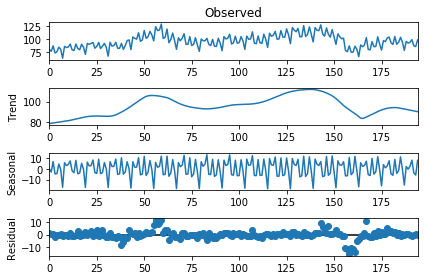

In [19]:
ee_stl = STL(ee.elecequip.values, period=12, robust=True).fit()
ee_stl.plot();

In [20]:
from pmdarima import auto_arima, model_selection


ee_adj = ee_stl.observed - ee_stl.seasonal
ee_train, ee_test = model_selection.train_test_split(ee_adj, train_size=150)
ee_arima = auto_arima(ee_train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=707.575, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=724.165, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=715.304, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=713.256, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=722.821, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=712.176, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=707.187, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=715.144, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=710.610, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=703.640, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=703.060, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=704.363, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=705.507, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=702.067, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=710.5

`pmdarima` yields a ARIMA(3,1,1) model with an AIC = 676. The example in FPP2 manually selected ARIMA(3,1,1). Let's look at the predictions.

In [21]:
ee_predict, ee_ci = ee_arima.predict(ee_test.shape[0], return_conf_int=True)

In [22]:
ee_forecast = (
    pd.DataFrame(
        {
            "predicted": ee_predict,
            "actual": ee_test.flatten(),
        }
    )
    .join(pd.DataFrame(ee_ci).rename(columns={0: "lower_ci", 1: "upper_ci"}))
#     .stack()
    .reset_index()
#     .rename(columns={"level_0": "index", "level_1": "label"})
)
line_predicted_elec = (
    alt.Chart(ee_forecast)
    .mark_line()
    .encode(x="index:O", y="predicted:Q")
    .properties(width=800)
)
line_actual_elec = line_predicted_elec.mark_line(color='orange').encode(x="index:O", y="actual")
band_elec = line_predicted_elec.mark_area(opacity=0.5).encode(x="index", y="lower_ci:Q", y2="upper_ci:Q")

In [23]:
#TODO: fix top x-axis
line_predicted_elec + line_actual_elec + band_elec

alt.LayerChart(...)

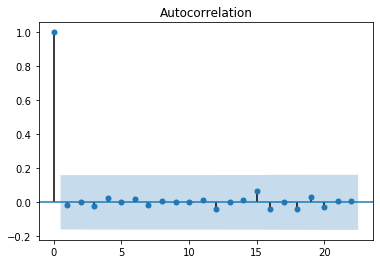

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ee_residuals = ee_arima.predict_in_sample() - ee_train
plot_acf(ee_residuals);

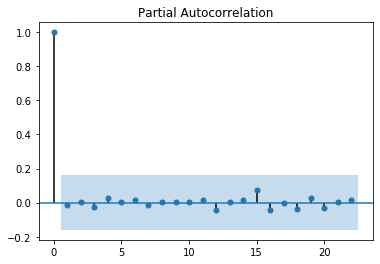

In [25]:
plot_pacf(ee_residuals);

In [26]:
#TODO: weird outlier at -80?
alt.Chart(pd.DataFrame({"residuals": ee_residuals})).mark_bar().encode(
    alt.X("residuals:Q", bin=alt.Bin(maxbins=30)), y="count():Q"
)

alt.Chart(...)